### Advanced Notebook: requesting the TerraCatalog and calculate NDVI ourselves
In Terrascope, you can request the catalogue to retrieve the various products that are stored. Below we start with importing the necessary packages for putting the requests, as well as the other more standard packages.

If you ran other notebooks before this one, make sure to shut down all kernels before reconnecting to the 3.6 kernel and running this script, otherwise you might run out of memory.

In [2]:
import datetime as dt                                     # date and time functions  
import os                                                 # operating system functions
import rasterio                                           # raster files 
import matplotlib.pyplot as mplot                         # plotting functions
from mpl_toolkits.axes_grid1 import make_axes_locatable   # more plotting functions
import seaborn as sns                                     # extended plotting possibilities wrt matplotlib
import glob                                               # alternative to using os, file/directory searches etc.
import numpy as np                                        # standard Python numpy
import sys                                                # standard Python system package

### Product types

#### Terrascope Sentinel Product types
First, we have a look at the different Sentinel Product Types available in the catalog.

In [8]:
catalog_base_url = 'https://services.terrascope.be/catalogue/'

def get_collections(platform):
    
    import requests
    from urllib.parse import urljoin

    headers = {'Accept': 'application/json'}
    payload = {
        'platform': platform,
    }
    response = requests.get(urljoin(catalog_base_url, 'collections'),
                            headers = headers,
                            params = payload)

    collections = []
    if response.status_code == requests.codes.ok:
        result = response.json()
        for feature in result['features']:
            collections.append(feature['id'])
        return collections
    else:
        print(response.status_code)
        print(response.json())
        response.raise_for_status()

In [3]:
s1_platform = 'SENTINEL-1'
s1_collections = get_collections(s1_platform)
print('Found {} {} collections:'.format(len(s1_collections), s1_platform))
print(s1_collections)

s2_platform = 'SENTINEL-2'
s2_collections = get_collections(s2_platform)
print('Found {} {} collections:'.format(len(s2_collections), s2_platform))
print(s2_collections)

Found 4 SENTINEL-1 collections:
['urn:eop:VITO:CGS_S1_GRD_L1', 'urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1', 'urn:eop:VITO:CGS_S1_SLC_L1', 'urn:eop:VITO:TERRASCOPE_S1_SLC_COHERENCE_V1']
Found 8 SENTINEL-2 collections:
['urn:eop:VITO:CGS_S2_L1C', 'urn:eop:VITO:TERRASCOPE_S2_CCC_V2', 'urn:eop:VITO:TERRASCOPE_S2_CWC_V2', 'urn:eop:VITO:TERRASCOPE_S2_FAPAR_V2', 'urn:eop:VITO:TERRASCOPE_S2_FCOVER_V2', 'urn:eop:VITO:TERRASCOPE_S2_LAI_V2', 'urn:eop:VITO:TERRASCOPE_S2_NDVI_V2', 'urn:eop:VITO:TERRASCOPE_S2_TOC_V2']


S1 and S2 relate to the Sentinel-1 and -2 satellites, respectively. The Sentinel-2 products are also split up per resolution. This is not just a change in spatial resolution:
* the 10 m resolution FAPAR, LAI, and FCOVER indices use just the 10m band information 
* the 20 m resolution FAPAR, LAI, and FCOVER indices use 10 m <b>and</b> 20 m band information

### Products

#### Sentinel products
Below the catalog is requested to provide a list of the number of products available and over which time period.

In [4]:
def get_nbr_of_products(collection):
    import requests
    from urllib.parse import urljoin

    headers = {'Accept': 'application/json'}
    payload = {
        'collection': collection,
    }
    response = requests.get(urljoin(catalog_base_url, 'products'),
                            headers = headers,
                            params = payload)

    collections = []
    if response.status_code == requests.codes.ok:
        result = response.json()
        return result['totalResults']
    else:
        print(response.status_code)
        print(response.json())
        response.raise_for_status()

In [5]:
for collection in s2_collections:
    nbr = get_nbr_of_products(collection)
    print('{}: {} products'.format(collection, nbr))

urn:eop:VITO:CGS_S2_L1C: 178612 products
urn:eop:VITO:TERRASCOPE_S2_CCC_V2: 267788 products
urn:eop:VITO:TERRASCOPE_S2_CWC_V2: 267788 products
urn:eop:VITO:TERRASCOPE_S2_FAPAR_V2: 535572 products
urn:eop:VITO:TERRASCOPE_S2_FCOVER_V2: 535574 products
urn:eop:VITO:TERRASCOPE_S2_LAI_V2: 535576 products
urn:eop:VITO:TERRASCOPE_S2_NDVI_V2: 267788 products
urn:eop:VITO:TERRASCOPE_S2_TOC_V2: 267271 products


#### Products in a selected area, within a predefined time window
To narrow down, below we provide a list of Sentinel products for a pre-defined time window over a selected area.
In this case, we want to select the COG (Cloud Optimized GeoTIFF) fAPAR data for 1 - 5 July 2018 for the region 51 - 52$^o$N, 4 - 5$^o$E.
The TerraCatalogue exposes all necessary information, including bands containing related data (e.g. cloud mask) and a cloud cover percentage.

In [6]:
def get_products(collection, startDate, endDate, bbox = None, tileId = None):
    import requests
    from urllib.parse import urljoin

    headers = {'Accept': 'application/json'}
    payload = {
        'collection': collection,
        'start': startDate.strftime('%Y-%m-%d'),
        'end': endDate.strftime('%Y-%m-%d'),
        'accessedFrom': 'MEP'
    }
    if bbox is not None:
        payload['bbox'] = bbox
    if tileId is not None:
        payload['tileId'] = tileId        
    
    response = requests.get(urljoin(catalog_base_url, 'products'),
                            headers = headers,
                            params = payload)

    if response.status_code == requests.codes.ok:
        result = response.json()
        return result['features']
    else:
        print(response.status_code)
        print(response.json())
        response.raise_for_status()

In [8]:
collection   = 'urn:eop:VITO:TERRASCOPE_S2_FAPAR_V2' # choose any product type in the lists we made earlier
startDate    = dt.date(2018,7,1)
endDate      = dt.date(2018,7,5)
minLatitude  = 51 #in decimal degrees, positive for North
maxLatitude  = 52
minLongitude = 4 #in decimal degrees, positive for East
maxLongitude = 5

products = get_products(collection, startDate, endDate,
                       '{},{},{},{}'.format(minLongitude, minLatitude, maxLongitude, maxLatitude))

print('Found {} products:'.format(len(products)))
for product in products:
    print(product['properties']['title'])

Found 10 products:
S2A_20180703T105621_31UES_FAPAR_10M_V200
S2A_20180703T105621_31UES_FAPAR_20M_V200
S2A_20180703T105621_31UET_FAPAR_10M_V200
S2A_20180703T105621_31UET_FAPAR_20M_V200
S2B_20180702T104019_31UES_FAPAR_10M_V200
S2B_20180702T104019_31UES_FAPAR_20M_V200
S2B_20180702T104019_31UFS_FAPAR_10M_V200
S2B_20180702T104019_31UFS_FAPAR_20M_V200
S2B_20180702T104019_31UFT_FAPAR_10M_V200
S2B_20180702T104019_31UFT_FAPAR_20M_V200


Let's open one of the files.

Once the data are read, we can convert them to physical values and plot the results. 
Also here, we do not yet read the conversion factors from the metadata, but use the hard coded value. 
Physical values > 1 are finally set to NaN (non-clear pixels).

In [20]:
f_fapar = products[0]['properties']['links']['data'][0]['href']

with rasterio.open(f_fapar, 'r') as data:
    d_fapar=data.read(1).astype('uint8') #the FAPAR values are stored as byte data
  

0.0 0.975


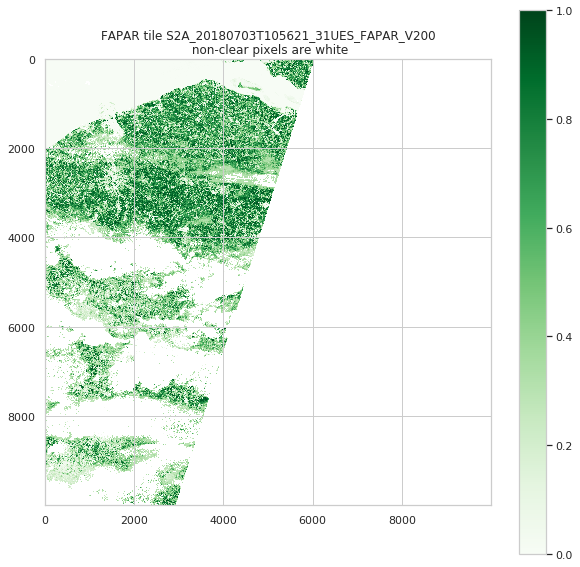

In [21]:
#set the seaborn plotting environment
sns.set()
sns.set_style("whitegrid")

#Take a subset, change these values if necessary
sub = np.array([0, 10000])

#Set NoData --> NaN, convert DN --> PV: for now use hard coded value
fapar_sub = d_fapar[sub[0]:sub[1],sub[0]:sub[1]]

fapar_sub[fapar_sub == 255] = -1
fapar_sub = fapar_sub * 0.005
fapar_sub[fapar_sub > 1.] = np.nan
print(np.nanmin(fapar_sub), np.nanmax(fapar_sub))

#create map plots for the RED and NIR and resulting NDVI, use subplots
mplot.figure(figsize=(10,10))
#mplot.subplot(111) # we only want to plot one subplot

#show the FAPAR values
mplot.imshow(fapar_sub, cmap='Greens', vmin=0., vmax=1.0)
mplot.colorbar()

#there are many colormaps that you can use. See here: https://matplotlib.org/examples/color/colormaps_reference.html
mplot.title('FAPAR tile ' + f_fapar.split('/')[10] + '\n non-clear pixels are white')

# free up some resources
d_fapar   = None
sub       = None
fapar_sub = None

Now, let's do some processing. 
1. we will look for the raw 10 m Sentinel-2 bands 
2. then we load the RED (B04) and NIR (B08) bands to calculate the NDVI
3. and we show the results

In [9]:
collection = 'urn:eop:VITO:TERRASCOPE_S2_TOC_V2' 
startDate = dt.date(2018,5,6)
endDate = dt.date(2018,5,7)
minLatitude = 51 
maxLatitude = 52
minLongitude = 4 
maxLongitude = 5
tileId = '31UES'

products = get_products(collection, startDate, endDate,
                       '{},{},{},{}'.format(minLongitude, minLatitude, maxLongitude, maxLatitude), tileId)

print('Found {} products:'.format(len(products)))
for product in products:
    print(product['properties']['title'])

Found 1 products:
S2B_20180506T105029_31UES_TOC_V200


Data are stored in folders, with some more interesting data:
* bands containing the data
* related bands (cloud shadow masks, AOT data, scene classification)
* XML INSPIRE metdata

This information is all exposed by the TerraCatalogue.

Let's do some processing on the data. We'll derive the NDVI from the Red and NIR bands.

In [10]:
product = products[0]
print(product['properties']['title'])

for band in product['properties']['links']['data']:
    if band['title'] =='TOC-B04_10M': #red
        f_red = band['href']   
    if band['title'] =='TOC-B08_10M': #near-infrared
        f_nir = band['href']   

#read the files with rasterio 
with rasterio.open(f_red, 'r') as data:
    d_red = data.read(1).astype(float)
      
with rasterio.open(f_nir, 'r') as data:
    d_nir = data.read(1).astype(float)

S2B_20180506T105029_31UES_TOC_V200


During the atmospheric correction, some pixel values may become nonsensical (e.g. negative values). We'll take care of that. Furthermore, we'll convert the greyvalues into physical values, by applying the scale factor (which we found in the xml file).

In [11]:
#select the values that should be discarded from both the RED and NIR TOC reflectances
noval = np.where((d_red == 32767) | (d_red < 0) | (d_nir == 32767) | (d_nir < 0))    
d_red[noval] = np.nan
d_nir[noval] = np.nan

#apply the scaling factor
d_red = d_red * 0.0001 
d_nir = d_nir * 0.0001

#compute the NDVI from RED and NIR
d_ndvi = (d_red - d_nir) / (d_red + d_nir)

Now, we'll show the original data and the NDVI derived from it. NDVI has values in the [-1,1] interval

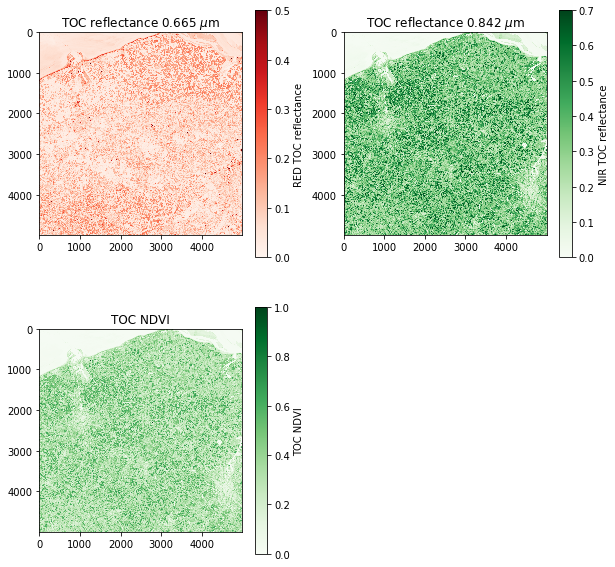

In [12]:
#take a subset, in this case the upper left quadrant
sub = np.array([500, 5500])

#make map plots for the RED and NIR and resulting NDVI, use subplots
mplot.figure(figsize=(10,10))
mplot.subplot(221)

#TOC reflectances
mplot.imshow(d_red[sub[0]:sub[1],sub[0]:sub[1]], cmap='Reds', vmin=0., vmax=0.5)
mplot.title('TOC reflectance 0.665 $\mu$m')

cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('RED TOC reflectance')
cb.ax.tick_params(labelsize=10)

mplot.subplot(222)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Greens', vmin=0., vmax=0.7)
mplot.title('TOC reflectance 0.842 $\mu$m')
cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('NIR TOC reflectance')
cb.ax.tick_params(labelsize=10)

#TOC NDVI
mplot.subplot(223)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Greens', vmin=0., vmax=1.0)
mplot.title('TOC NDVI')

#same as for the TOC reflectance colorbar, but now for TOC NDVI
cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('TOC NDVI')
cb.ax.tick_params(labelsize=10)